# Gradient Boosting – Wine Quality (binaire)

Ce notebook applique **Gradient Boosting** selon le cahier des charges :
- Classification avancée
- Souvent plus précise que AdaBoost
- Classification binaire : quality ≥6 → bon, <6 → moyen/mauvais
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-gradient-boosting")

2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:12:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:12:10 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:12:10 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/2', creation_time=1770929428913, experiment_id='2', last_update_time=1770929428913, lifecycle_stage='active', name='wine-quality-gradient-boosting', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

# Cible binaire
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]
feature_names = X.columns.tolist()

# Normalisation
X_scaled, scaler = scale_features(X)

# Train/test split
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")

Train set: 1087 échantillons
Test set: 272 échantillons


## 3. Entraînement du modèle

In [3]:
gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.761
F1-score: 0.772
Precision: 0.780
Recall: 0.764

Matrice de confusion:
[[ 97  31]
 [ 34 110]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       128
           1       0.78      0.76      0.77       144

    accuracy                           0.76       272
   macro avg       0.76      0.76      0.76       272
weighted avg       0.76      0.76      0.76       272



## 4. Feature importance

Feature importance:
                 feature  importance
10               alcohol    0.425596
9              sulphates    0.154582
6   total sulfur dioxide    0.088070
1       volatile acidity    0.087013
4              chlorides    0.050049
0          fixed acidity    0.039700
7                density    0.037444
8                     pH    0.036007
3         residual sugar    0.034788
2            citric acid    0.028661
5    free sulfur dioxide    0.018089


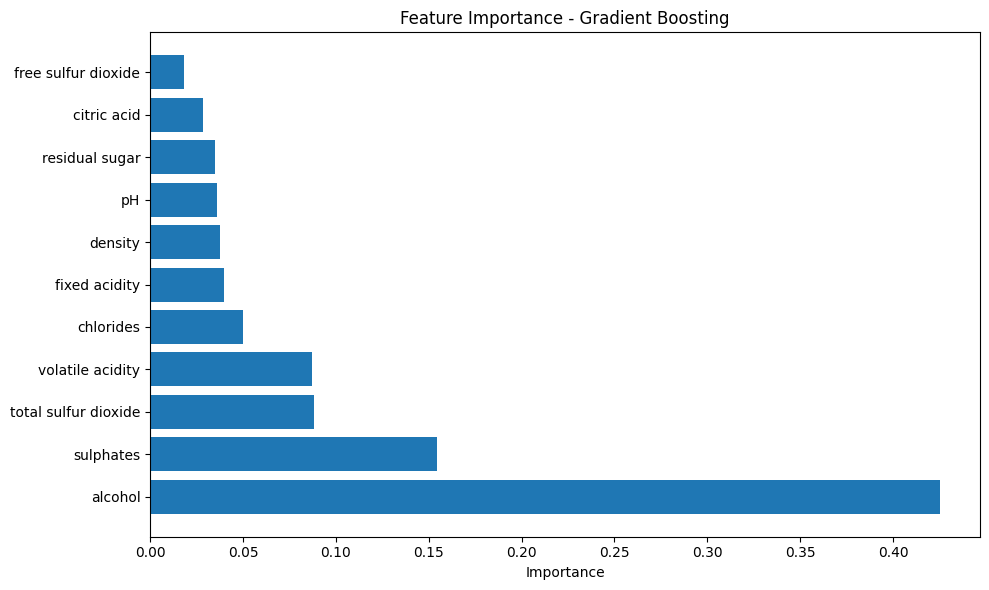

In [4]:
# Importance des features
feature_importance = gb_clf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(importance_df)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.savefig("gradientboosting_feature_importance.png")
plt.show()

## 5. Visualisation de la matrice de confusion

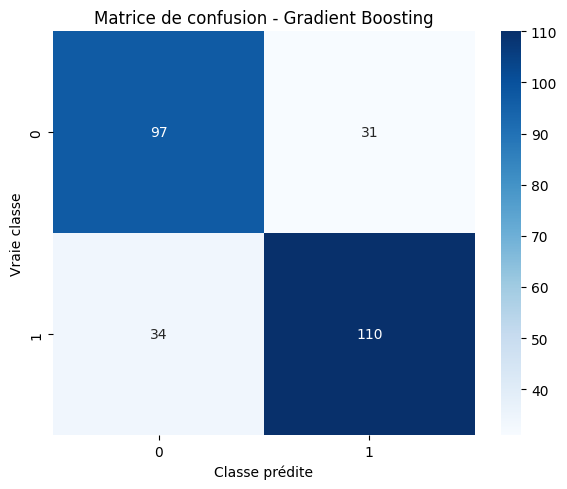

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - Gradient Boosting')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("gradientboosting_confusion_matrix.png")
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name="GradientBoosting_binary"):
    mlflow.log_params(gb_clf.get_params())
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    
    # Log feature importance
    for idx, row in importance_df.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", float(row['importance']))
    
    mlflow.log_artifact("gradientboosting_feature_importance.png")
    mlflow.log_artifact("gradientboosting_confusion_matrix.png")
    mlflow.sklearn.log_model(gb_clf, "gradient_boosting_model")
    print("MLflow run terminé")

2026/02/14 17:12:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
